In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
# from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func
import numpy as np
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
import tensorflow as tf

C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# uncomment to disable GPU
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# reduce memory usage, in case you're
# on a machine with 1 GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print (gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        _tf_on_gpu = True
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


# Case 1

10.0

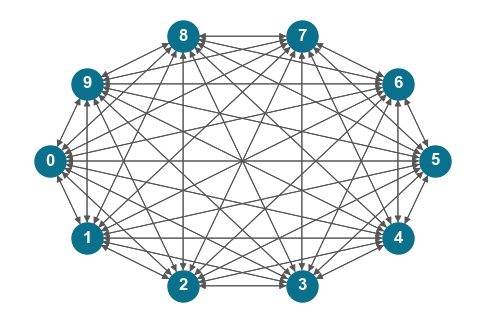

In [3]:
graph_1, edge_list_1, node_list_1 = maxentep.gen_graph(10)
# fig, ax = plt.subplots(dpi=100)

# nx.draw(graph, with_labels=True, pos=nx.shell_layout(graph) , font_weight='bold', ax=ax, **options)
maxentep.draw_graph(graph_1, dpi =100)
dof_1 = maxentep.graph_dof(graph_1.edges(), node_list_1)
dof_1

Reference Model

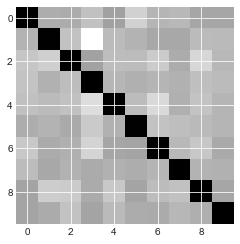

In [4]:
# Make up some population area and mobility network
np.random.seed(0)
M = 10
patches=[f'patch {i}' for i in range(M)]
population = np.round(np.random.normal(loc=500000, scale=300000, size=(M,)))
area = np.maximum(300, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
mobility_matrix = np.round(np.abs(np.random.normal(loc=100, scale=50, size=(M,M))))
# setting diagonal values to be dominant
# mobility_matrix[1,:]= 0
# mobility_matrix[:,1]= 0
mobility_matrix_diag = np.round(np.abs(np.random.normal(loc=100000, scale=3000, size=(M))))
np.fill_diagonal(mobility_matrix, mobility_matrix_diag)
mobility_matrix_norm = mobility_matrix / np.sum(mobility_matrix, axis=1, keepdims=True)
plt.imshow(np.log(mobility_matrix))
# np.diagonal(mobility_matrix)
compartments = ['E', 'A', 'I', 'R']
full_compartments = ['S'] + compartments
infections_compartments = [1,2]
C = len(compartments)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


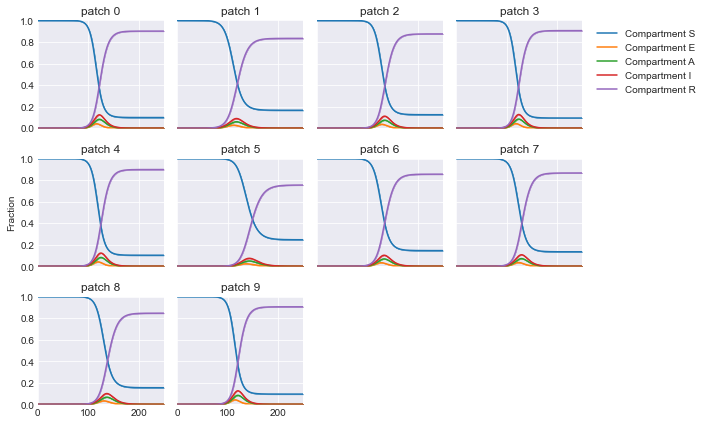

In [5]:
def gen_ref_traj(beta_A = 0.025, beta_I=0.04, alpha =1/3, gamma=1/2, mu=1/7, M=10, timesteps=100, mobility_matrix=mobility_matrix, population=None, area= None):
    tmat = maxentep.TransitionMatrix(compartments, [1,2])
#     eta = 1/2
#     alpha = 1/2
#     mu = 1/5
    tmat.add_transition('E', 'A', 1/alpha, 0) # call this alpha
    tmat.add_transition('E', 'I', 1/gamma, 0) # call this gamma
    tmat.add_transition('A', 'R',1/mu, 0) # mu
    tmat.add_transition('I', 'R', 1/mu, 0) # mu
    infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
#     timesteps = 250
    model = maxentep.MetaModel(infect_fxn, timesteps, populations=np.array(population))

    # starting fractions probabilities
    start = np.zeros((M,C)) #anywhere
    # Assume starting from Node 1
    initial_exposed = 1/population[1]
    start[1,0] = initial_exposed
    # start[0,0] = 0.05
#     beta = 0.03
    mobility_matrix_norm = mobility_matrix / np.sum(mobility_matrix, axis=1, keepdims=True)
    ref_traj = model(mobility_matrix_norm, tmat.value, start, np.array([beta_A,beta_I]))[0]
    ref_traj = ref_traj[tf.newaxis, ...]
    return ref_traj
ref_traj_1 = gen_ref_traj(M=10, timesteps=250, population=population,
                          area=area, mobility_matrix=mobility_matrix)
maxentep.patch_quantile(ref_traj_1, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])

Add Restraints

Restraints are set in this time range: [100, 130]
122 0.115495555 0.11485970902444628
115 0.07794935 0.07862578585737402
108 0.03758618 0.03816276944720538
101 0.014988111 0.014779812576480911
122 0.31115723 0.31115736617446216
115 0.15111935 0.15262518974980924
108 0.061619554 0.06172407463833399
101 0.022865044 0.022629000802483326
122 0.12317771 0.12389193101566166
115 0.08916437 0.09144870216273984
108 0.044133984 0.045698086132184526
101 0.017458897 0.018070000793863436
101 0.02596897 0.02531179370168331
122 0.35336334 0.35268235605328646
108 0.07138787 0.07174264176429908
115 0.17553817 0.1741040129637092
101 0.004769402 0.004024647268411622
122 0.06262032 0.06179388088740071
115 0.03021369 0.030115236907122686
108 0.012455157 0.011791678717934672
108 0.019925488 0.018778019506649375
101 0.0074247397 0.006986919610362826
122 0.12316705 0.12266902041433608
115 0.05154792 0.053477450522530744
115 0.09844407 0.0981869392036958
122 0.12172008 0.12352990074600849
101 0.022719767 0.023

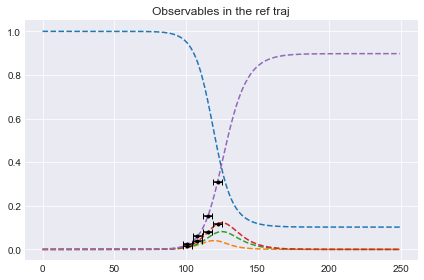

In [6]:
npoints = 4
number_of_restrained_patches = 5
restrained_compartments = [3,4] #(infected patch and recovered)
number_of_restrained_compartments = len(restrained_compartments) 
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
restrained_compartments_names = " ".join(restrained_compartments_names)
def gen_restraints(ref_traj):
    prior = maxentep.EmptyPrior()

    restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)
    # Visualizing restraints
    restrained_patch = restrained_patches[0]
    restraints, plot_fxns_list = maxentep.compartment_restrainer(restrained_patches, restrained_compartments,
                                                                 ref_traj, prior, npoints = npoints, noise=0.001, start_time=100, end_time=130)
    plt.plot(ref_traj[0,:,restrained_patch,:], linestyle='--')
    for i,pf in enumerate(plot_fxns_list[0]):
        pf(plt.gca(), 0)
    plt.title('Observables in the ref traj')
    plt.tight_layout()
    return restraints, plot_fxns_list, restrained_patches
restraints_1, plot_fxns_list_1, restrained_patches_1 = gen_restraints(ref_traj_1)

# Sample

In [7]:
def gen_samples(mobility_matrix, timesteps =250, area = area, populations = population):
    tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
    tmat.add_transition('E', 'A', 2, 1) # call this alpha
    tmat.add_transition('E', 'I', 2, 1) # call this gamma
    tmat.add_transition('A', 'R',5, 2) # mu
    tmat.add_transition('I', 'R', 5, 2)
    hyper_pram = maxentep.ParameterHypers()
    hyper_pram.beta_low = [0.005]*2
    hyper_pram.beta_high = [0.08]*2
    hyper_pram.beta_var = [0.1]*2
    hyper_pram.start_high = 2e-5
    hyper_pram.start_var = 0.5
    hyper_pram.R_var = 100
    hyper_pram.beta_start = 0.005
    hyper_pram.start_mean = 8e-6
    hyper_pram.start_scale = 4e-6
    start_logits = np.zeros((M))
    param_model = maxentep.MetaParameterJoint(start_logits, mobility_matrix , tmat, name='unbiased_model',
                                              hypers = hyper_pram, n_infectious_compartments=2)
    import tqdm
    N = 512
    batches = 8
    total_batches = N * batches
    outs = []
    infect = maxentep.contact_infection_func(infections_compartments, area = area)
    model = maxentep.MetaModel(infect, timesteps, populations = population)
    prior_prams = []
    for b in tqdm.tqdm(range(batches)):
        ps = param_model.sample(N)
        prior_prams.append(ps)
        outs.append(model(*ps))
    trajs = np.concatenate(outs, axis=0)
    param_batch = prior_prams[0]
    mask = tf.greater(param_batch[2], 0)
    start_exposed_dist = tf.boolean_mask(param_batch[2], mask).numpy()
    # prior_param_dist = maxentep.get_dist(prior_prams)
    # maxentep.plot_dist(*prior_param_dist)
    return trajs
trajs_1 = gen_samples(mobility_matrix, timesteps =250, area = area, populations = population)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:26<00:00,  3.31s/it]


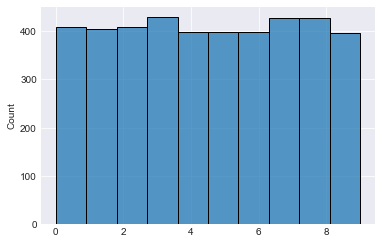

In [8]:
prior_exposed_patch_1 = maxentep.exposed_finder(trajs_1)
# print(np.where(prior_exposed_patch==0))
sns.histplot(x=prior_exposed_patch_1, label='Prior',
            color='C0',bins=M)

In [9]:
def compare_to_ref(ref_traj, trajs, weights, *args, method = None, figsize=(18, 18), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments] and compares to a ref_traj
    '''
#     weights = weights_dict[method]
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.06)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.002)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[0,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                maxentep.traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
            if j >= NP % ncol:
                ax[nrow-1, j].set_visible(False)
    plt.tight_layout()

Plotting 10 patches in a 3 x 4 grid


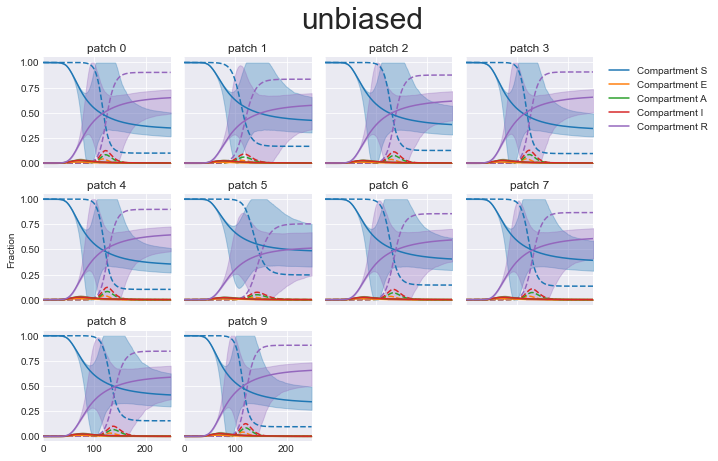

In [10]:
compare_to_ref(ref_traj_1,trajs_1, weights=None, method='unbiased', patch_names = patches,
               figsize=(10, 6), alpha=0.3, names=full_compartments)

# Applying MaxEnt

Epoch 1/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0238 - weight-entropy: 6.6020
Epoch 2/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0192 - weight-entropy: 6.2474
Epoch 3/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0201 - weight-entropy: 6.2103
Epoch 4/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0198 - weight-entropy: 6.2126
Epoch 5/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0187 - weight-entropy: 6.2305
Epoch 6/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0166 - weight-entropy: 6.2518
Epoch 7/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0130 - weight-entropy: 6.2414
Epoch 8/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0089 - weight-entropy: 6.1210
Epoch 9/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0089 - weight-entropy: 5.7940
Epoch 10/500
4/4 [==============================] - 0s 2ms/step - loss: 0

4/4 [==============================] - 0s 3ms/step - loss: 0.0071 - weight-entropy: 5.1911
Epoch 80/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0074 - weight-entropy: 5.1106
Epoch 81/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0069 - weight-entropy: 5.1173
Epoch 82/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0069 - weight-entropy: 5.1072
Epoch 83/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0073 - weight-entropy: 5.1974
Epoch 84/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0070 - weight-entropy: 5.0376
Epoch 85/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0070 - weight-entropy: 5.0026
Epoch 86/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0070 - weight-entropy: 5.0802
Epoch 87/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0069 - weight-entropy: 5.0553
Epoch 88/500
4/4 [==============================] - 0s 2ms/step - loss: 0.006

4/4 [==============================] - 0s 2ms/step - loss: 0.0042 - weight-entropy: 4.0710
Epoch 157/500
4/4 [==============================] - 0s 4ms/step - loss: 0.0045 - weight-entropy: 3.9629
Epoch 158/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0048 - weight-entropy: 3.9082
Epoch 159/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0041 - weight-entropy: 3.9289
Epoch 160/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0043 - weight-entropy: 4.1276
Epoch 161/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0045 - weight-entropy: 4.0200
Epoch 162/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0044 - weight-entropy: 3.9516
Epoch 163/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0042 - weight-entropy: 4.0673
Epoch 164/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0044 - weight-entropy: 3.8795
Epoch 165/500
4/4 [==============================] - 0s 2ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0047 - weight-entropy: 3.5730
Epoch 234/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0038 - weight-entropy: 3.3203
Epoch 235/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0036 - weight-entropy: 3.0624
Epoch 236/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0037 - weight-entropy: 2.8463
Epoch 237/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0036 - weight-entropy: 3.1185
Epoch 238/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0037 - weight-entropy: 2.8563
Epoch 239/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 2.8510
Epoch 240/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0030 - weight-entropy: 2.8453
Epoch 241/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0037 - weight-entropy: 3.0746
Epoch 242/500
4/4 [==============================] - 0s 2ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 2.1476
Epoch 311/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 2.3172
Epoch 312/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0044 - weight-entropy: 3.1362
Epoch 313/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 2.6100
Epoch 314/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 2.3766
Epoch 315/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0036 - weight-entropy: 2.8918
Epoch 316/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 2.3665
Epoch 317/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 2.2977
Epoch 318/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0033 - weight-entropy: 2.6712
Epoch 319/500
4/4 [==============================] - 0s 2ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 2.2326
Epoch 389/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 1.7293
Epoch 390/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 2.2690
Epoch 391/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0037 - weight-entropy: 1.7884
Epoch 392/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0037 - weight-entropy: 2.1426
Epoch 393/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 2.2257
Epoch 394/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0049 - weight-entropy: 2.5747
Epoch 395/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0036 - weight-entropy: 2.3781
Epoch 396/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 1.8877
Epoch 397/500
4/4 [==============================] - 0s 2ms/step - lo

4/4 [==============================] - 0s 3ms/step - loss: 0.0034 - weight-entropy: 2.1620
Epoch 467/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0032 - weight-entropy: 2.0141
Epoch 468/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 2.0402
Epoch 469/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 1.4255
Epoch 470/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 1.8067
Epoch 471/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 1.7567
Epoch 472/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 1.2635
Epoch 473/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 1.8016
Epoch 474/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 1.8141
Epoch 475/500
4/4 [==============================] - 0s 3ms/step - lo

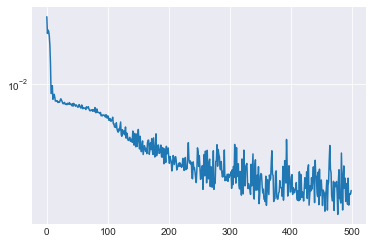

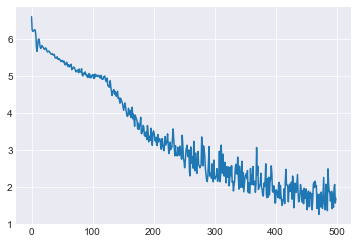

In [11]:
def maxent_fit(trajs,restraints):
    me_model = maxentep.MaxentModel(restraints)
    me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-1), 'mean_squared_error')
    me_history = me_model.fit(trajs, batch_size=1024,epochs=500)
    plt.plot(me_history.history['loss'])
    plt.yscale('log')
    plt.show()
    plt.plot(me_history.history['weight-entropy'])
    return me_model
me_model_1 = maxent_fit(trajs_1, restraints_1)

In [12]:
def compare_patches(ref_traj, trajs,weights_dict, method, restrained_patches,plot_fxns_list,
                    *args, figsize=(10, 6), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments]
    '''
    weights = weights_dict[method]
#     p = 1
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.03)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.03)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[0,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                maxentep.traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
#             ax[i, j].set_ylim(0, 1)
            if i * ncol + j in restrained_patches and method != 'unbiased':
                for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i * ncol + j)]):
                    pf(ax[i,j],0, color='C3')
                ax[i,j].spines['bottom'].set_color('y')
                ax[i,j].spines['top'].set_color('y') 
                ax[i,j].spines['right'].set_color('y')
                ax[i,j].spines['left'].set_color('y')
                ax[i,j].spines['left'].set_linewidth(2)
                ax[i,j].spines['top'].set_linewidth(2)
                ax[i,j].spines['right'].set_linewidth(2)
                ax[i,j].spines['bottom'].set_linewidth(2)
#             plt.tight_layout()
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
            if j >= NP % ncol:
                ax[nrow-1, j].set_visible(False)
    plt.tight_layout()


Plotting 10 patches in a 3 x 4 grid


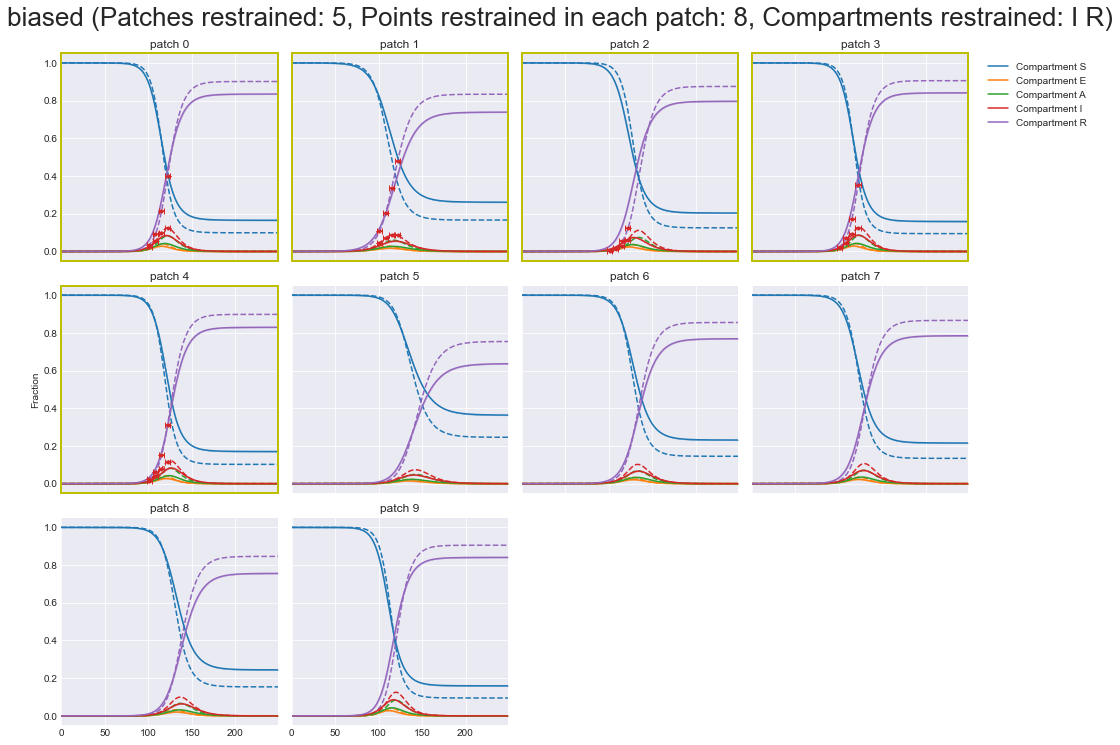

In [13]:
weights_dict_1 = {'unbiased':None, 'biased':me_model_1.traj_weights}
compare_patches(ref_traj_1, trajs_1, weights_dict_1,'biased', restrained_patches_1,plot_fxns_list_1,
                patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

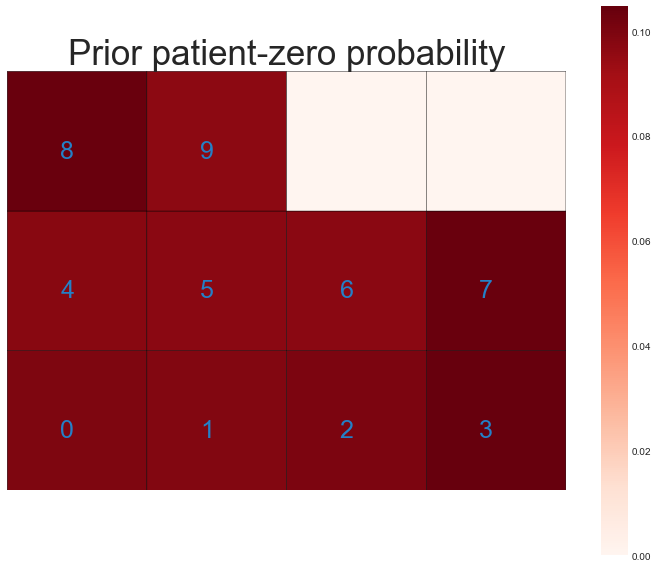

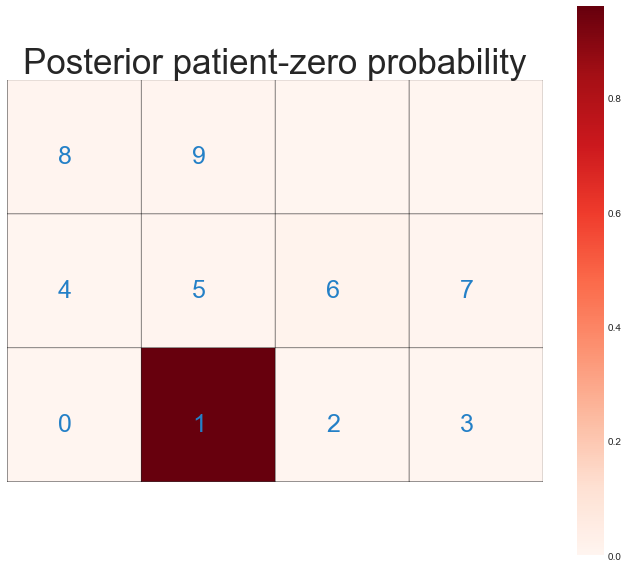

In [14]:
prior_exposed_patch_1 = maxentep.exposed_finder(trajs_1)
me_w_1 = me_model_1.traj_weights
maxentep.p0_map(prior_exposed_patch_1, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch_1, M, weights = me_w_1, title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))

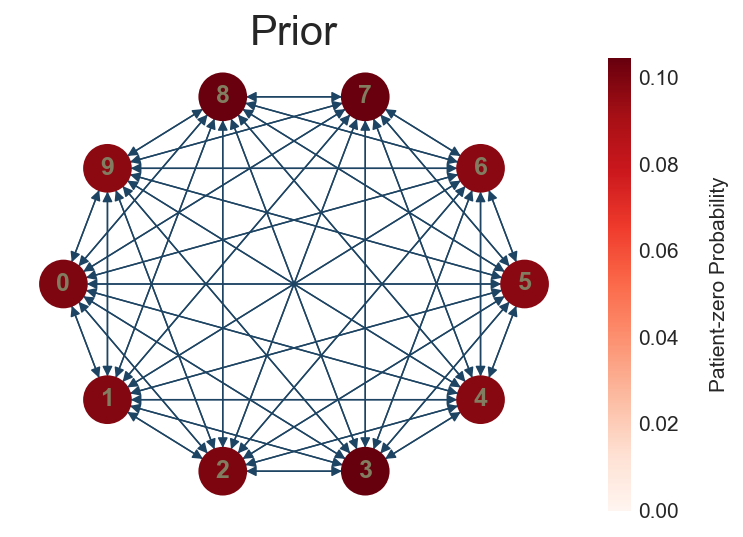

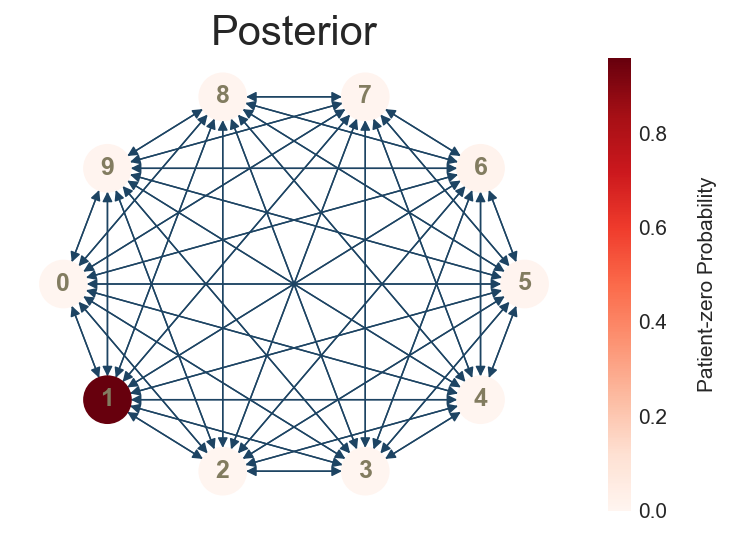

In [15]:
exposed_prob_1 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_1, M)
weighted_exposed_prob_1 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_1, M, weights=me_w_1)
maxentep.draw_graph(graph_1, weights=exposed_prob_1, title='Prior', heatmap=True)
fig, ax = plt.subplots()
maxentep.draw_graph(graph_1, weights=weighted_exposed_prob_1, title='Posterior', heatmap=True)

In [16]:
def p0_loss(trajs, weights, M=10, true_p0_node=1):
    '''Returns cross-entropy loss for p0 based on sampled trajs and maxent weights inputs'''
    prior_exposed_patch = maxentep.exposed_finder(trajs)
    weighted_exposed_prob = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch, M, weights=weights)
    true_p0 = np.zeros(M)
    true_p0[true_p0_node] = 1
    loss = np.sum(-(true_p0 * np.log(weighted_exposed_prob) + (1-true_p0)*np.log(1-weighted_exposed_prob)))
    return loss


def traj_loss(ref_traj, trajs, weights):
    '''Returns RMSE loss for predicted traj based on ref_traj, sampled trajs and maxent weights inputs'''
    M = trajs.shape[2]
    Time = trajs.shape[1]
    c = trajs.shape[-1]
    weights /= tf.reduce_sum(weights)
    mtrajs_counties = tf.reduce_sum(trajs * weights[:, tf.newaxis, tf.newaxis,tf.newaxis], axis=0)
    rmse = tf.math.sqrt(tf.reduce_mean((ref_traj[0] - mtrajs_counties)**2))
    return rmse
traj_rmse_1 = traj_loss(ref_traj_1, trajs_1, me_w_1)
p0_loss_1 = p0_loss(trajs_1,me_w_1)

In [17]:
# posterior_exposed_prob = maxentep.weighted_exposed_prob_finder(prior_exposed_patch, M, weights = me_w)
print(f'P0 cross-entropy : {p0_loss_1:.3f}, Traj RMSE : {traj_rmse_1:.3f}')
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob_1, patches), reverse=True)[:5])


P0 cross-entropy : 0.081, Traj RMSE : 0.039
Top 5 posterior probabilities for P0: 
 [(0.960013492747167, 'patch 1'), (0.012516748579982015, 'patch 6'), (0.006476140429862658, 'patch 5'), (0.00590555979272153, 'patch 7'), (0.005242771191516149, 'patch 9')]


 # Case 2

6.9

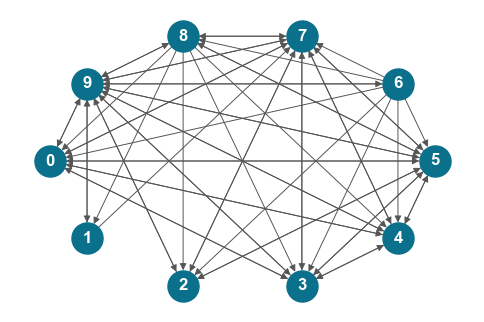

In [18]:
graph_2, edge_list_2, node_list_2 = maxentep.gen_graph(10)
# fig, ax = plt.subplots(dpi=100)
graph_2.remove_edges_from([(1, i) for i in range(0,7) if i!=1])
graph_2.remove_edges_from([(i, 1) for i in range(0,8)  if i!=1])
graph_2.remove_edges_from([(2, i) for i in range(0,5) if i!=2])
graph_2.remove_edges_from([(i,2) for i in range(0,5)  if i!=2])
graph_2.remove_edges_from([(i,8) for i in range(0,5)  if i!=8])
graph_2.remove_edges_from([(i,6) for i in range(0,9)  if i!=6])
maxentep.draw_graph(graph_2, dpi=100)
# nx.draw(graph_2, with_labels=True, pos=nx.shell_layout(graph_2) , font_weight='bold', ax=ax, **options)
dof_2 = maxentep.graph_dof(graph_2.edges(), node_list_2)
dof_2

In [19]:
def sparse_graph_mobility(sparse_graph, fully_connected_mobility_matrix):
    R'''
    Generates a sprase mobility matrix based on a sparse graph and a fully connected mobility matrix inputs
    '''
    sparse_mobility_matrix = np.zeros_like(fully_connected_mobility_matrix)
    for i, edge in enumerate(sparse_graph.edges()):
        sparse_mobility_matrix[edge[0], edge[1]] = fully_connected_mobility_matrix[edge[0], edge[1]]
    return sparse_mobility_matrix


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


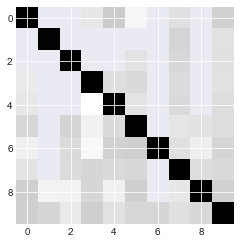

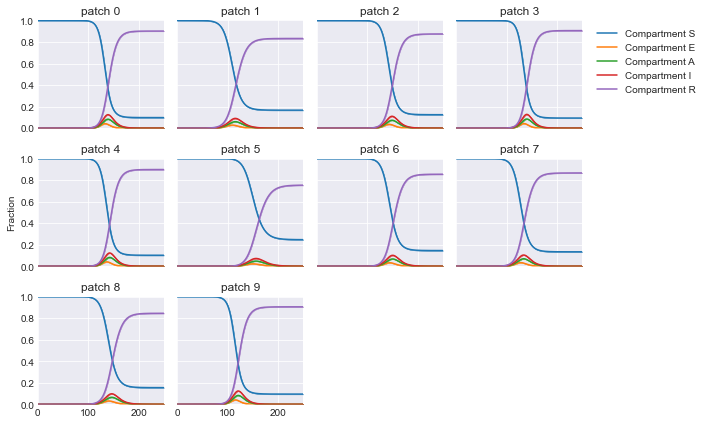

In [20]:
sparse_mobility_matrix_2 = sparse_graph_mobility(graph_2, mobility_matrix)
plt.imshow(np.log(sparse_mobility_matrix_2))
sparse_ref_traj_2 = gen_ref_traj(M=10, timesteps=250, population=population,
                               area=area, mobility_matrix=sparse_mobility_matrix_2)
maxentep.patch_quantile(sparse_ref_traj_2, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])

Restraints are set in this time range: [100, 130]
115 0.10540361 0.10429922623441265
108 0.061291493 0.06134365855469814
122 0.120776124 0.12003656130218122
101 0.026829911 0.02837292599131414
101 0.042077936 0.04157304002379087
122 0.43633083 0.4358860672877964
115 0.24324894 0.24362607571002845
108 0.10875301 0.10811590413073087
122 0.0120278215 0.012420129559235491
108 0.0016564392 0.0018980739618951357
115 0.004590985 0.004694920811829031
101 0.00057700824 0.0
108 0.0024070926 0.0017311926696753988
122 0.018957015 0.018034468801464747
115 0.006881315 0.006432728449767701
101 0.0008227728 0.0010047518948559494
101 0.053787287 0.05488694692055409
108 0.07896448 0.0796197429983198
122 0.079048894 0.07968902587185794
115 0.08983905 0.0882220926393325
115 0.38220358 0.3835865212834353
101 0.13148151 0.13186842621934666
108 0.23989142 0.2385589715956383
122 0.526785 0.5272888335442849
108 0.0031417892 0.003663776961054763
115 0.009099903 0.010297162450006782
122 0.024537044 0.02415455743

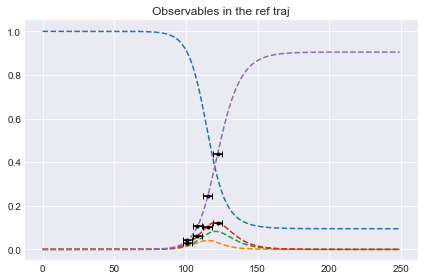

In [21]:
restraints_2, plot_fxns_list_2, restrained_patches_2 = gen_restraints(sparse_ref_traj_2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.05s/it]


Plotting 10 patches in a 3 x 4 grid


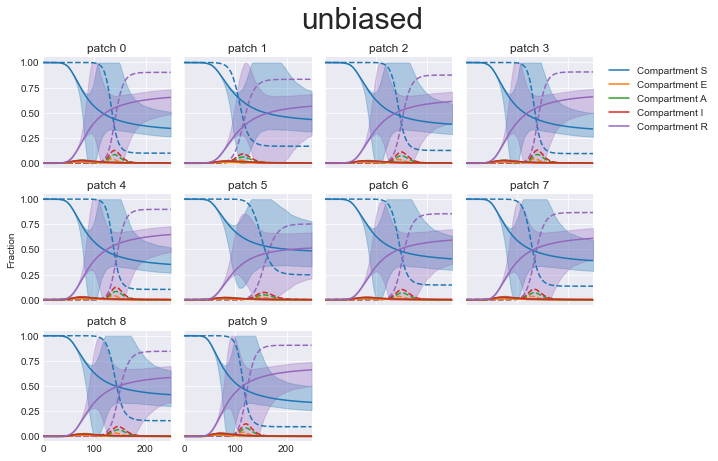

In [22]:
sparse_trajs_2 = gen_samples(sparse_mobility_matrix_2, timesteps =250, area = area, populations = population)
compare_to_ref(sparse_ref_traj_2, sparse_trajs_2, weights=None, method='unbiased',
               patch_names = patches, figsize=(10, 6), alpha=0.3, names=full_compartments)

Epoch 1/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0251 - weight-entropy: 6.6118
Epoch 2/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0171 - weight-entropy: 6.2507
Epoch 3/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0179 - weight-entropy: 6.1947
Epoch 4/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0180 - weight-entropy: 6.1787
Epoch 5/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0180 - weight-entropy: 6.1763
Epoch 6/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0179 - weight-entropy: 6.1812
Epoch 7/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0177 - weight-entropy: 6.1900
Epoch 8/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0174 - weight-entropy: 6.2027
Epoch 9/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0170 - weight-entropy: 6.2166
Epoch 10/500
4/4 [==============================] - 0s 2ms/step - loss: 0

4/4 [==============================] - 0s 3ms/step - loss: 0.0028 - weight-entropy: 4.3383
Epoch 80/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.2692
Epoch 81/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.0986
Epoch 82/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0021 - weight-entropy: 4.1449
Epoch 83/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 4.2172
Epoch 84/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1710
Epoch 85/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 4.3038
Epoch 86/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0028 - weight-entropy: 4.1507
Epoch 87/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0022 - weight-entropy: 4.0782
Epoch 88/500
4/4 [==============================] - 0s 2ms/step - loss: 0.002

4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.2421
Epoch 157/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.1696
Epoch 158/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.0678
Epoch 159/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 2.8917
Epoch 160/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 2.9648
Epoch 161/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 2.9770
Epoch 162/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 2.9311
Epoch 163/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 3.0569
Epoch 164/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.0285
Epoch 165/500
4/4 [==============================] - 0s 2ms/step - lo

4/4 [==============================] - 0s 3ms/step - loss: 0.0011 - weight-entropy: 2.4257
Epoch 234/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0013 - weight-entropy: 2.4252
Epoch 235/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0011 - weight-entropy: 2.6116
Epoch 236/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 2.6375
Epoch 237/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 2.6103
Epoch 238/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.0465
Epoch 239/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 2.8669
Epoch 240/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 2.8063
Epoch 241/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0012 - weight-entropy: 2.6006
Epoch 242/500
4/4 [==============================] - 0s 3ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 2.2063
Epoch 311/500
4/4 [==============================] - 0s 4ms/step - loss: 0.0013 - weight-entropy: 2.4845
Epoch 312/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0011 - weight-entropy: 2.3914
Epoch 313/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 2.3795
Epoch 314/500
4/4 [==============================] - 0s 3ms/step - loss: 7.1705e-04 - weight-entropy: 2.2163
Epoch 315/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 2.5987
Epoch 316/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 2.1435
Epoch 317/500
4/4 [==============================] - 0s 2ms/step - loss: 9.9029e-04 - weight-entropy: 2.1533
Epoch 318/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0011 - weight-entropy: 2.1302
Epoch 319/500
4/4 [==============================] - 0s 2ms/s

4/4 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 2.6334
Epoch 388/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 2.2499
Epoch 389/500
4/4 [==============================] - 0s 3ms/step - loss: 7.5862e-04 - weight-entropy: 1.9347
Epoch 390/500
4/4 [==============================] - 0s 2ms/step - loss: 9.7364e-04 - weight-entropy: 1.9522
Epoch 391/500
4/4 [==============================] - 0s 3ms/step - loss: 9.9924e-04 - weight-entropy: 1.9587
Epoch 392/500
4/4 [==============================] - 0s 2ms/step - loss: 9.0810e-04 - weight-entropy: 2.1892
Epoch 393/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 2.1693
Epoch 394/500
4/4 [==============================] - 0s 2ms/step - loss: 7.3628e-04 - weight-entropy: 2.2506
Epoch 395/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 2.3631
Epoch 396/500
4/4 [==============================

4/4 [==============================] - 0s 2ms/step - loss: 7.1411e-04 - weight-entropy: 1.8832
Epoch 465/500
4/4 [==============================] - 0s 3ms/step - loss: 7.6322e-04 - weight-entropy: 1.9341
Epoch 466/500
4/4 [==============================] - 0s 3ms/step - loss: 6.9585e-04 - weight-entropy: 2.1073
Epoch 467/500
4/4 [==============================] - 0s 2ms/step - loss: 9.1485e-04 - weight-entropy: 2.0587
Epoch 468/500
4/4 [==============================] - 0s 3ms/step - loss: 7.3422e-04 - weight-entropy: 1.8414
Epoch 469/500
4/4 [==============================] - 0s 2ms/step - loss: 8.0162e-04 - weight-entropy: 1.7577
Epoch 470/500
4/4 [==============================] - 0s 2ms/step - loss: 8.9119e-04 - weight-entropy: 1.8150
Epoch 471/500
4/4 [==============================] - 0s 2ms/step - loss: 6.9081e-04 - weight-entropy: 1.7578
Epoch 472/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 1.7257
Epoch 473/500
4/4 [==================

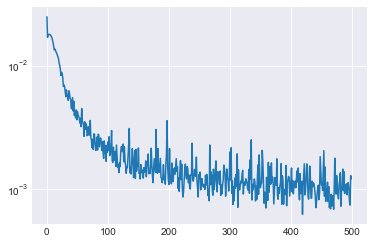

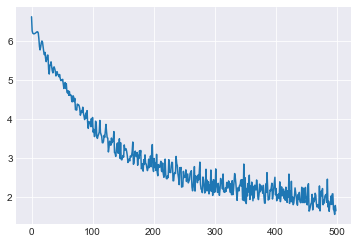

In [23]:
sparse_me_model_2 = maxent_fit(sparse_trajs_2, restraints_2)

Plotting 10 patches in a 3 x 4 grid


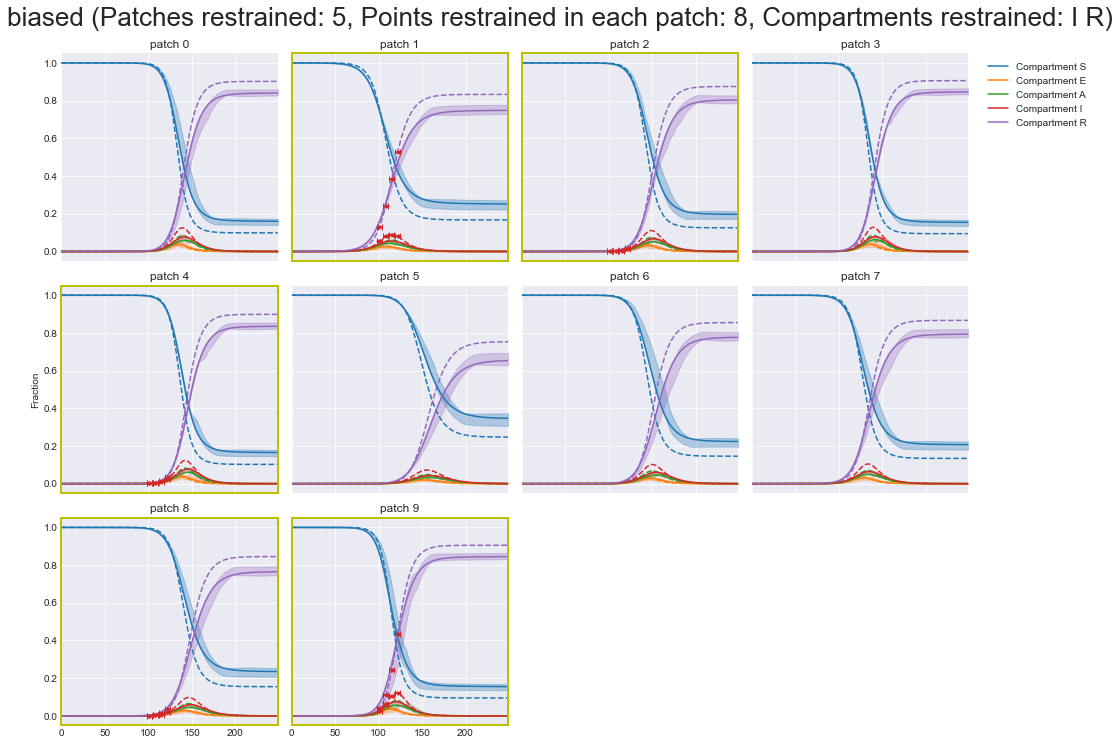

In [24]:
weights_dict_2 = {'unbiased':None, 'biased':sparse_me_model_2.traj_weights}
compare_patches(sparse_ref_traj_2, sparse_trajs_2, weights_dict_2,'biased', restrained_patches_2, plot_fxns_list_2,
                patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

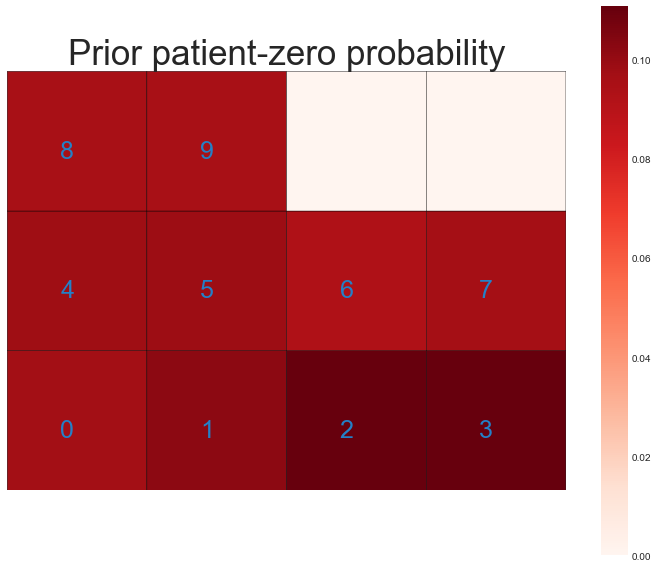

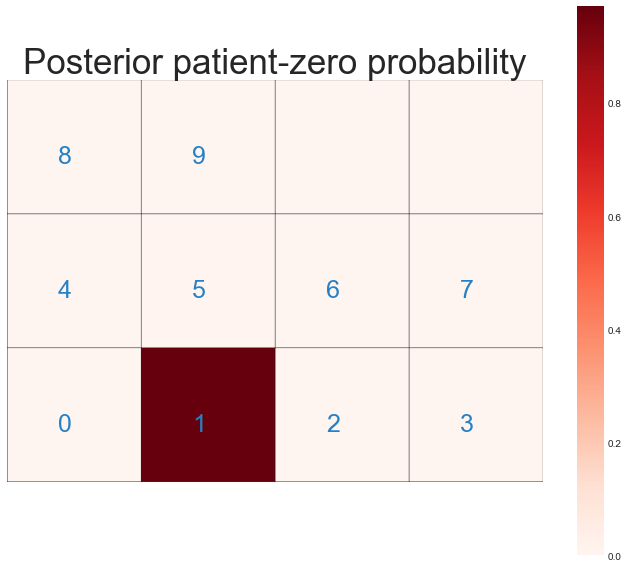

In [25]:
me_w_2 = sparse_me_model_2.traj_weights
prior_exposed_patch_2 = maxentep.exposed_finder(sparse_trajs_2)
maxentep.p0_map(prior_exposed_patch_2, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch_2, M, weights = me_w_2, 
                title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))

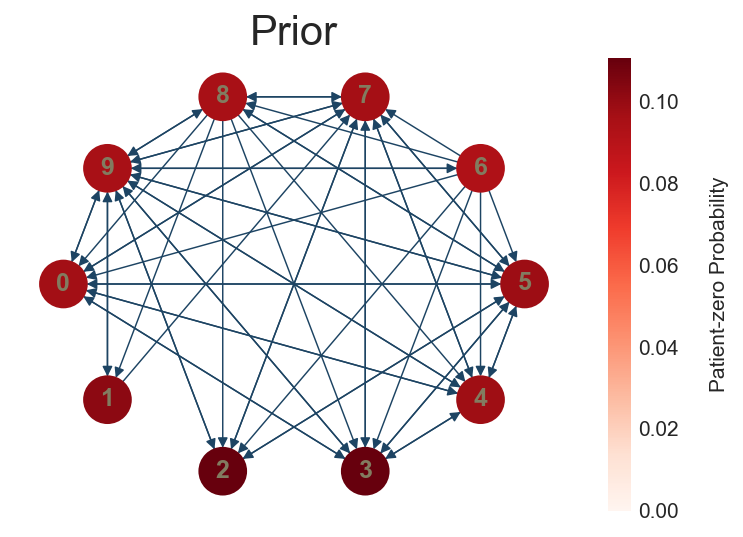

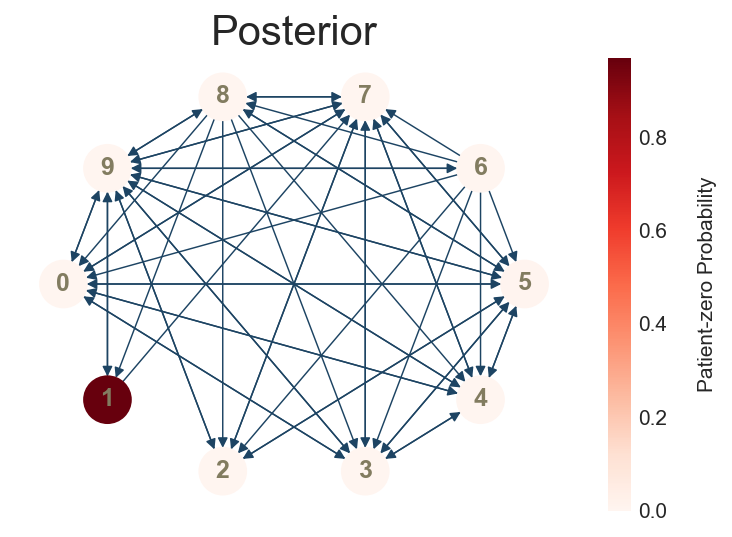

In [26]:
exposed_prob_2 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_2, M)
weighted_exposed_prob_2 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_2, M, weights=me_w_2)
maxentep.draw_graph(graph_2, weights=exposed_prob_2, title='Prior', heatmap=True)
fig, ax = plt.subplots()
maxentep.draw_graph(graph_2, weights=weighted_exposed_prob_2, title='Posterior', heatmap=True)

In [27]:
traj_rmse_2 = traj_loss(sparse_ref_traj_2, sparse_trajs_2, me_w_2)
p0_loss_2 = p0_loss(sparse_trajs_2,me_w_2)
print(f'P0 cross-entropy : {p0_loss_2:.3f}, Traj RMSE : {traj_rmse_2:.3f}')
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob_2, patches), reverse=True)[:5])

P0 cross-entropy : 0.058, Traj RMSE : 0.038
Top 5 posterior probabilities for P0: 
 [(0.9712800291533759, 'patch 1'), (0.004227151854303447, 'patch 5'), (0.0036824642578127675, 'patch 6'), (0.0032956899498392408, 'patch 8'), (0.0032637234473047653, 'patch 7')]


# Case 3

4.5

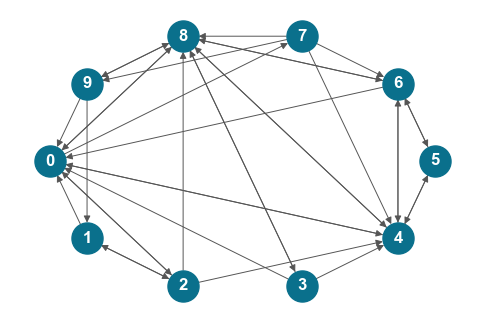

In [28]:
graph_3, edge_list_3, node_list_3 = maxentep.gen_graph(10)
graph_3.remove_edges_from([(1, i) for i in range(3,9)])
graph_3.remove_edges_from([(i, 1) for i in range(0,9) if i != 2 and i != 1])
graph_3.remove_edges_from([(i, 2) for i in range(3,9) ])
graph_3.remove_edges_from([(i, 6) for i in range(0,4)])
graph_3.remove_edges_from([(i, 7) for i in range(1,10) if i != 7])
graph_3.remove_edges_from([(7, i) for i in range(0,5) if i!=4])
graph_3.remove_edges_from([(5, i) for i in range(0,9) if i!=6 and i!=4 and i!=5])
graph_3.remove_edges_from([(i, 5) for i in range(0,9)  if i!=6 and i!=4 and i!=5])
graph_3.remove_edges_from([(i, 3) for i in range(0,7) if i!=3])
graph_3.remove_edges_from([(9,i) for i in range(2,8)])
graph_3.remove_edges_from([(i,9) for i in range(0,7)])
# graph.remove_edges_from([(i,4) for i in range(0,7)])
maxentep.draw_graph(graph_3,dpi=100)
dof_3 = maxentep.graph_dof(graph_3.edges(), node_list_3)
dof_3


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


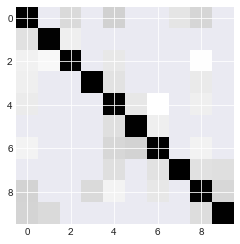

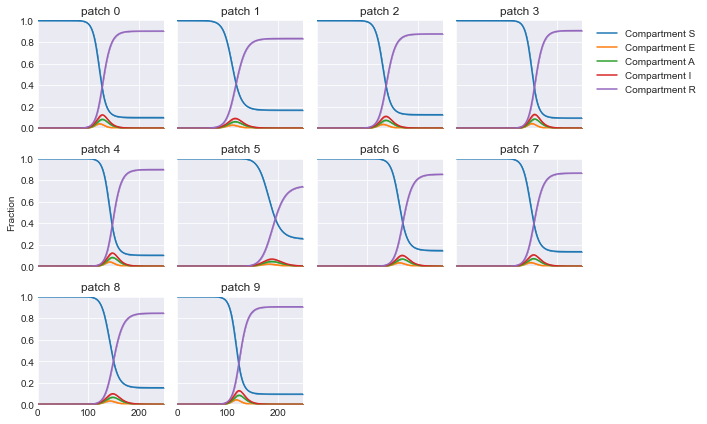

In [29]:
sparse_mobility_matrix_3 = sparse_graph_mobility(graph_3, mobility_matrix)
plt.imshow(np.log(sparse_mobility_matrix_3))
sparse_ref_traj_3 = gen_ref_traj(M=10, timesteps=250, population=population,
                               area=area, mobility_matrix=sparse_mobility_matrix_3)
maxentep.patch_quantile(sparse_ref_traj_3, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])

Restraints are set in this time range: [100, 130]
108 0.07932959 0.07847258662961296
122 0.07875639 0.07954551468702183
101 0.054224607 0.05286246868181182
115 0.08985967 0.09108730479940177
115 0.38460368 0.3859314618761032
101 0.13277724 0.13267596236639795
108 0.24190617 0.24110302468931852
122 0.5289671 0.5285027448090223
101 0.00011550881 0.0
115 0.001144348 0.0006340552055945905
122 0.003491231 0.0036751565018417927
108 0.0003663238 0.0
122 0.004777879 0.002300781574926914
101 0.00015126461 0.0002375689836703515
108 0.00048477415 0.0017666933380429913
115 0.0015347337 0.0010643421944462482
101 5.631101e-06 0.0
115 5.5006116e-05 0.0
122 0.00016722619 0.0
108 1.7727842e-05 0.0
108 2.3599398e-05 0.0
115 7.4223884e-05 0.002576869332700511
122 0.00022977276 0.0004925683894440426
101 7.401649e-06 0.0
108 0.000114606264 0.0
115 0.00033398965 0.0
122 0.0009380054 0.0026929915499070123
101 3.8463822e-05 0.0
108 0.00016085627 0.0002634914324820603
115 0.0004780397 0.00044179977669814264
12

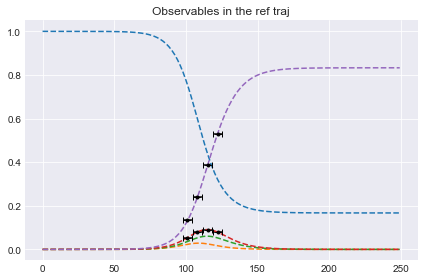

In [59]:
restraints_3, plot_fxns_list_3, restrained_patches_3 = gen_restraints(sparse_ref_traj_3)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.05s/it]


Plotting 10 patches in a 3 x 4 grid


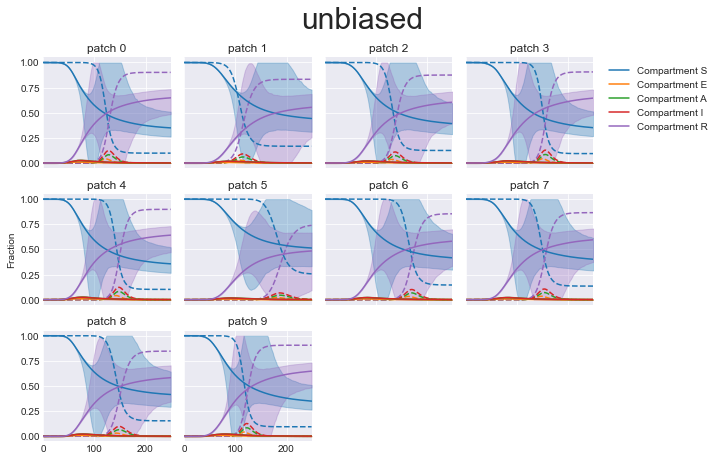

In [31]:
sparse_trajs_3 = gen_samples(sparse_mobility_matrix_3, timesteps =250, area = area, populations = population)
compare_to_ref(sparse_ref_traj_3, sparse_trajs_3, weights=None, method='unbiased', patch_names = patches,
               figsize=(10, 6), alpha=0.3, names=full_compartments)

Epoch 1/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0221 - weight-entropy: 6.6792
Epoch 2/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0120 - weight-entropy: 6.3695
Epoch 3/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0122 - weight-entropy: 6.3069
Epoch 4/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0123 - weight-entropy: 6.2814
Epoch 5/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0124 - weight-entropy: 6.2688
Epoch 6/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0124 - weight-entropy: 6.2633
Epoch 7/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0124 - weight-entropy: 6.2610
Epoch 8/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0124 - weight-entropy: 6.2605
Epoch 9/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0124 - weight-entropy: 6.2624
Epoch 10/500
4/4 [==============================] - 0s 2ms/step - loss: 0

4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 4.2113
Epoch 78/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 4.3966
Epoch 79/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 4.3806
Epoch 80/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 4.2833
Epoch 81/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 4.3383
Epoch 82/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.3199
Epoch 83/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 4.4834
Epoch 84/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.2820
Epoch 85/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.2064
Epoch 86/500
4/4 [==============================] - 0s 2ms/step - loss: 0.001

4/4 [==============================] - 0s 3ms/step - loss: 7.8001e-04 - weight-entropy: 3.6020
Epoch 155/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.8527
Epoch 156/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.8802
Epoch 157/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0011 - weight-entropy: 3.4686
Epoch 158/500
4/4 [==============================] - 0s 3ms/step - loss: 8.2116e-04 - weight-entropy: 3.6350
Epoch 159/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0016 - weight-entropy: 3.7272
Epoch 160/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 3.9460
Epoch 161/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.6798
Epoch 162/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.4754
Epoch 163/500
4/4 [==============================] - 0s 3ms/s

4/4 [==============================] - 0s 3ms/step - loss: 7.6097e-04 - weight-entropy: 3.2939
Epoch 232/500
4/4 [==============================] - 0s 2ms/step - loss: 9.1627e-04 - weight-entropy: 3.2394
Epoch 233/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.6502
Epoch 234/500
4/4 [==============================] - 0s 2ms/step - loss: 6.9210e-04 - weight-entropy: 3.3314
Epoch 235/500
4/4 [==============================] - 0s 3ms/step - loss: 9.3853e-04 - weight-entropy: 3.5632
Epoch 236/500
4/4 [==============================] - 0s 2ms/step - loss: 8.8109e-04 - weight-entropy: 3.4403
Epoch 237/500
4/4 [==============================] - 0s 2ms/step - loss: 7.6116e-04 - weight-entropy: 3.4454
Epoch 238/500
4/4 [==============================] - 0s 2ms/step - loss: 9.6940e-04 - weight-entropy: 3.7384
Epoch 239/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.6034
Epoch 240/500
4/4 [======================

4/4 [==============================] - 0s 2ms/step - loss: 6.5971e-04 - weight-entropy: 3.5272
Epoch 308/500
4/4 [==============================] - 0s 2ms/step - loss: 7.8295e-04 - weight-entropy: 3.3347
Epoch 309/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.9332
Epoch 310/500
4/4 [==============================] - 0s 2ms/step - loss: 8.0170e-04 - weight-entropy: 3.2437
Epoch 311/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.5706
Epoch 312/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 3.3967
Epoch 313/500
4/4 [==============================] - 0s 2ms/step - loss: 7.8778e-04 - weight-entropy: 3.1388
Epoch 314/500
4/4 [==============================] - 0s 2ms/step - loss: 9.6336e-04 - weight-entropy: 3.4605
Epoch 315/500
4/4 [==============================] - 0s 2ms/step - loss: 9.6176e-04 - weight-entropy: 3.1879
Epoch 316/500
4/4 [==========================

4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.7992
Epoch 384/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.6738
Epoch 385/500
4/4 [==============================] - 0s 2ms/step - loss: 9.3747e-04 - weight-entropy: 3.3907
Epoch 386/500
4/4 [==============================] - 0s 1ms/step - loss: 8.0083e-04 - weight-entropy: 3.0236
Epoch 387/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.5540
Epoch 388/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.1462
Epoch 389/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0010 - weight-entropy: 2.7743
Epoch 390/500
4/4 [==============================] - 0s 3ms/step - loss: 7.7980e-04 - weight-entropy: 3.2629
Epoch 391/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 3.2936
Epoch 392/500
4/4 [==============================] - 0s 2

4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.0765
Epoch 460/500
4/4 [==============================] - 0s 2ms/step - loss: 8.3684e-04 - weight-entropy: 3.1798
Epoch 461/500
4/4 [==============================] - 0s 2ms/step - loss: 6.5809e-04 - weight-entropy: 3.0235
Epoch 462/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.5394
Epoch 463/500
4/4 [==============================] - 0s 2ms/step - loss: 7.1514e-04 - weight-entropy: 3.0780
Epoch 464/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.3513
Epoch 465/500
4/4 [==============================] - 0s 2ms/step - loss: 7.9247e-04 - weight-entropy: 3.2811
Epoch 466/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.5170
Epoch 467/500
4/4 [==============================] - 0s 4ms/step - loss: 0.0012 - weight-entropy: 3.1669
Epoch 468/500
4/4 [==============================] - 

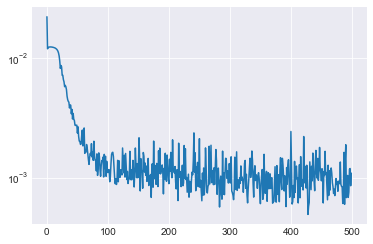

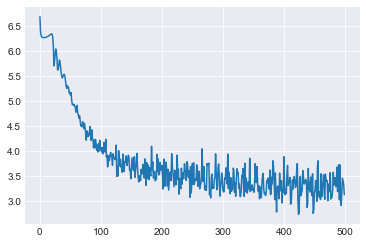

In [60]:
sparse_me_model_3 = maxent_fit(sparse_trajs_3, restraints_3)

Plotting 10 patches in a 3 x 4 grid


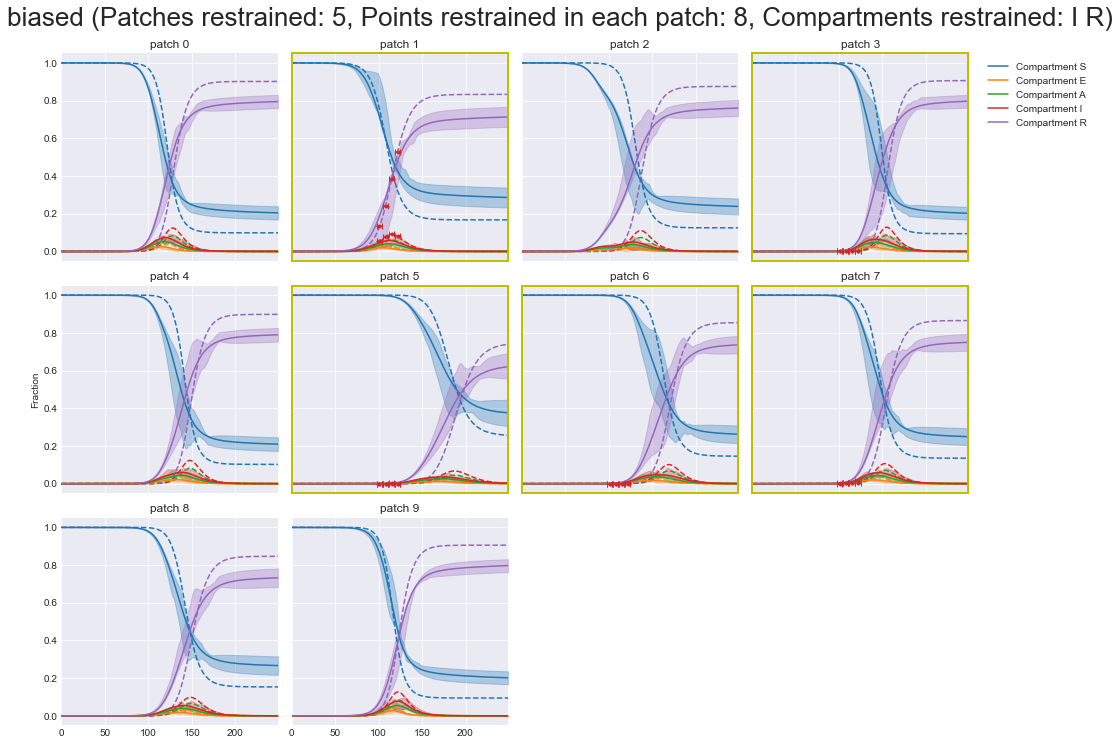

In [61]:
me_w_3 = sparse_me_model_3.traj_weights
weights_dict_3 = {'unbiased':None, 'biased':me_w_3}
compare_patches(sparse_ref_traj_3, sparse_trajs_3, weights_dict_3,'biased', restrained_patches_3, plot_fxns_list_3,
                patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

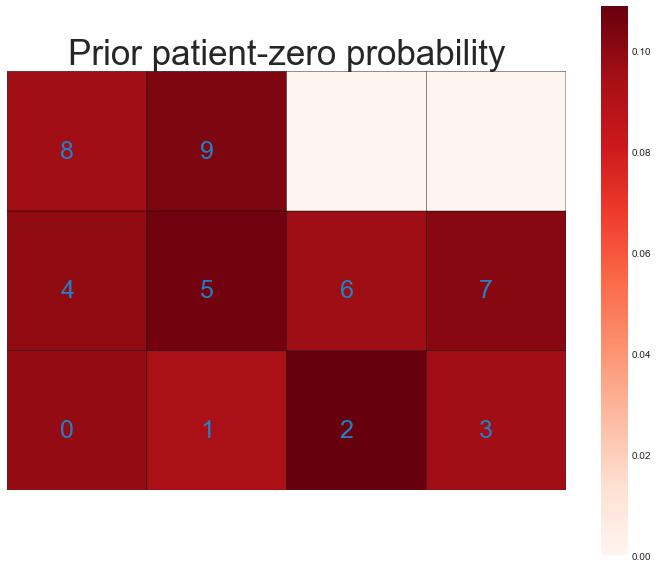

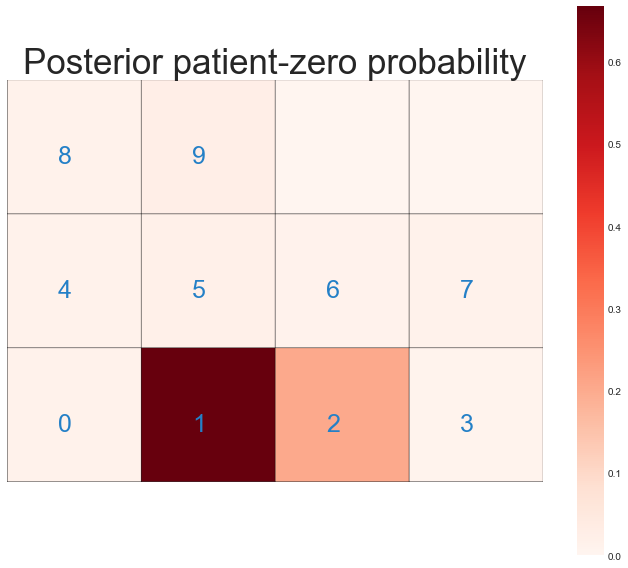

In [62]:
prior_exposed_patch_3 = maxentep.exposed_finder(sparse_trajs_3)
maxentep.p0_map(prior_exposed_patch_3, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch_3, M, weights = me_w_3, 
                title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))

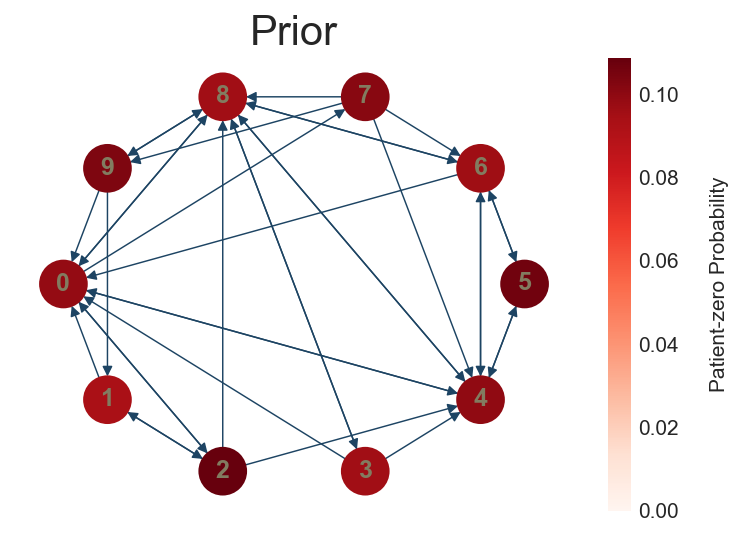

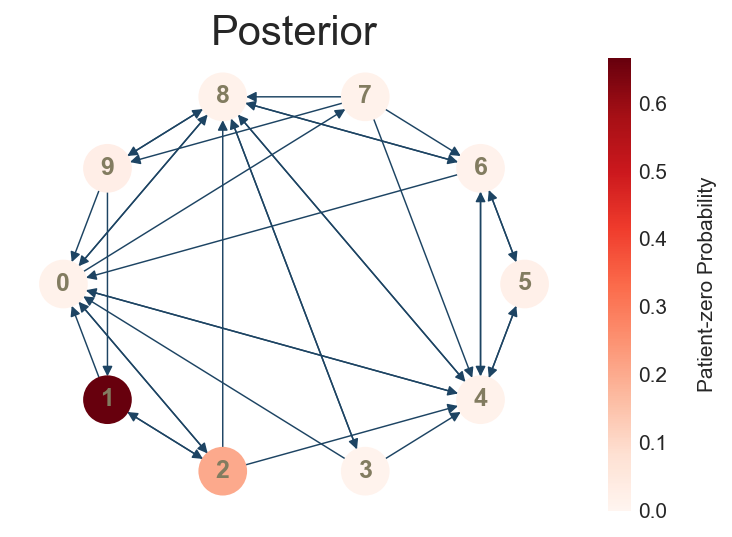

In [63]:
exposed_prob_3 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_3, M)
weighted_exposed_prob_3 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_3, M, weights=me_w_3)
maxentep.draw_graph(graph_3, weights=exposed_prob_3, title='Prior', heatmap=True)
fig, ax = plt.subplots()
maxentep.draw_graph(graph_3, weights=weighted_exposed_prob_3, title='Posterior', heatmap=True)

In [64]:
traj_rmse_3 = traj_loss(sparse_ref_traj_3, sparse_trajs_2, me_w_3)
p0_loss_3 = p0_loss(sparse_trajs_3,me_w_3)
print(f'P0 cross-entropy : {p0_loss_3:.3f}, Traj RMSE : {traj_rmse_3:.3f}')
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob_3, patches), reverse=True)[:5])

P0 cross-entropy : 0.763, Traj RMSE : 0.188
Top 5 posterior probabilities for P0: 
 [(0.6672309215521759, 'patch 1'), (0.2049031643271375, 'patch 2'), (0.027512384030535464, 'patch 9'), (0.020419957611779442, 'patch 5'), (0.015224672749507633, 'patch 8')]


# Case 4

3.3

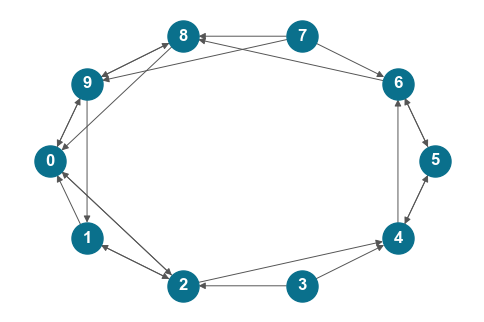

In [37]:
graph_4, edge_list_4, node_list_4 = maxentep.gen_graph(10)
graph_4.remove_edges_from([(1, i) for i in range(3,9)])
graph_4.remove_edges_from([(i, 1) for i in range(0,9) if i != 2 and i!=1])
graph_4.remove_edges_from([(i, 2) for i in range(4,9)])
graph_4.remove_edges_from([(i, 6) for i in range(0,4)])
graph_4.remove_edges_from([(i, 7) for i in range(1,10) if i!=7])
graph_4.remove_edges_from([(7, i) for i in range(0,5) if i!=4])
graph_4.remove_edges_from([(5, i) for i in range(0,9) if i!=6 and i!=4 and i!=5] )
graph_4.remove_edges_from([(i, 5) for i in range(0,9)  if i!=6 and i!=4 and i!=5])
graph_4.remove_edges_from([(i, 3) for i in range(0,7) if i!=3])
graph_4.remove_edges_from([(9,i) for i in range(2,8)])
graph_4.remove_edges_from([(i,9) for i in range(1,7)])
graph_4.remove_edges_from([(0, i) for i in range(3,9)])
graph_4.remove_edges_from([(i, 0) for i in range(3,8)])
graph_4.remove_edges_from([(i, 8) for i in range(2,6)])
graph_4.remove_edges_from([(8, i) for i in range(1,8) if i!=7 and i!=8])
graph_4.remove_edges_from([(i, 4) for i in range(6,9)])
maxentep.draw_graph(graph_4, dpi=100)
dof_4 = maxentep.graph_dof(graph_4.edges(), node_list_4)
dof_4


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


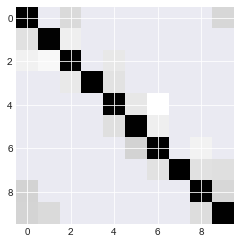

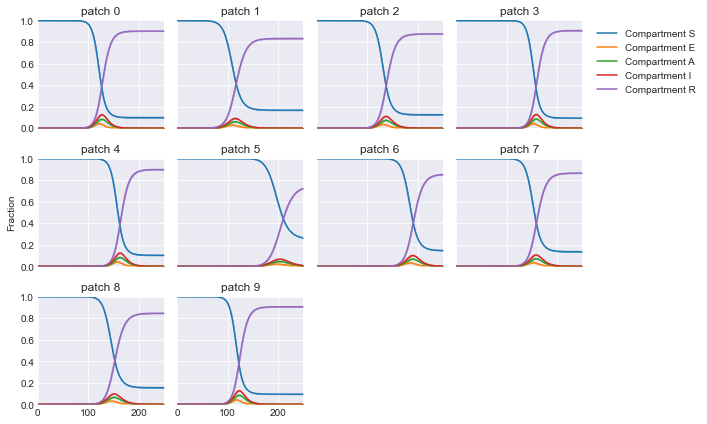

In [38]:
sparse_mobility_matrix_4 = sparse_graph_mobility(graph_4, mobility_matrix)
plt.imshow(np.log(sparse_mobility_matrix_4))
sparse_ref_traj_4 = gen_ref_traj(M=10, timesteps=250, population=population,
                          area=area, mobility_matrix=sparse_mobility_matrix_4)
maxentep.patch_quantile(sparse_ref_traj_4, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])


Restraints are set in this time range: [100, 130]
108 0.050144795 0.0501527616020285
115 0.09618567 0.09727424222204892
101 0.020411497 0.020490475284618677
122 0.12411823 0.12492431356879148
108 0.08317245 0.08206344334626997
115 0.19880949 0.1980065559358726
101 0.030739605 0.03161373892123786
122 0.38485312 0.38498818124680917
101 0.00018590406 0.00106173682557022
108 0.00055188616 0.00043677868957678106
122 0.00422632 0.004683735563745529
115 0.0015738044 0.0006091924029600186
115 0.0022887792 0.00300313642880492
101 0.00025586816 1.4800683945667063e-05
108 0.0007753609 0.0005994020931755472
122 0.0064798244 0.007491286150704501
101 0.011062703 0.010794448348721583
108 0.029202808 0.027904952574135285
115 0.06597315 0.06656920064149575
122 0.1099868 0.10912142154334149
115 0.117941044 0.11565340434503468
108 0.04565959 0.04510811638732145
101 0.016372513 0.017580133691027938
122 0.26084226 0.2596904656324971
108 0.07932925 0.0784953724919835
122 0.078763604 0.07712010081212257
115 

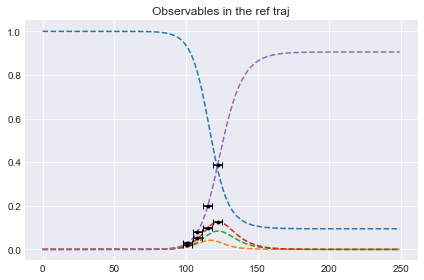

In [48]:
restraints_4, plot_fxns_list_4, restrained_patches_4 = gen_restraints(sparse_ref_traj_4)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:27<00:00,  3.38s/it]


Plotting 10 patches in a 3 x 4 grid


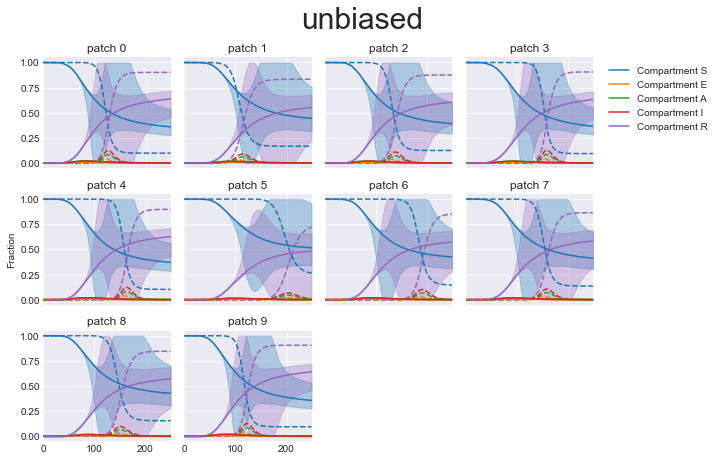

In [40]:
sparse_trajs_4 = gen_samples(sparse_mobility_matrix_4, timesteps =250, area = area, populations = population)
compare_to_ref(sparse_ref_traj_4, sparse_trajs_4, weights=None, method='unbiased', patch_names = patches,
               figsize=(10, 6), alpha=0.3, names=full_compartments)

Epoch 1/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0205 - weight-entropy: 6.6842
Epoch 2/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0179 - weight-entropy: 6.3908
Epoch 3/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0187 - weight-entropy: 6.3451
Epoch 4/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0188 - weight-entropy: 6.3371
Epoch 5/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0187 - weight-entropy: 6.3444
Epoch 6/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0183 - weight-entropy: 6.3617
Epoch 7/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0177 - weight-entropy: 6.3874
Epoch 8/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0167 - weight-entropy: 6.4210
Epoch 9/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0152 - weight-entropy: 6.4592
Epoch 10/500
4/4 [==============================] - 0s 3ms/step - loss: 0

4/4 [==============================] - 0s 2ms/step - loss: 0.0046 - weight-entropy: 4.8351
Epoch 80/500
4/4 [==============================] - ETA: 0s - loss: 0.0043 - weight-entropy: 4.43 - 0s 2ms/step - loss: 0.0043 - weight-entropy: 4.7687
Epoch 81/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0049 - weight-entropy: 4.9933
Epoch 82/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0037 - weight-entropy: 4.9087
Epoch 83/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0046 - weight-entropy: 4.8131
Epoch 84/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0049 - weight-entropy: 4.8803
Epoch 85/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0053 - weight-entropy: 4.8399
Epoch 86/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0053 - weight-entropy: 4.8141
Epoch 87/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0058 - weight-entropy: 4.7913
Epoch 88/500
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 0.0044 - weight-entropy: 4.4281
Epoch 157/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0044 - weight-entropy: 4.5509
Epoch 158/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0056 - weight-entropy: 4.9664
Epoch 159/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0037 - weight-entropy: 4.8052
Epoch 160/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0056 - weight-entropy: 4.8603
Epoch 161/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0043 - weight-entropy: 4.4802
Epoch 162/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0036 - weight-entropy: 4.5707
Epoch 163/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0052 - weight-entropy: 4.7393
Epoch 164/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 4.4744
Epoch 165/500
4/4 [==============================] - 0s 2ms/step - lo

4/4 [==============================] - 0s 4ms/step - loss: 0.0042 - weight-entropy: 4.6183
Epoch 235/500
4/4 [==============================] - 0s 4ms/step - loss: 0.0045 - weight-entropy: 4.7608
Epoch 236/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0038 - weight-entropy: 4.6226
Epoch 237/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0040 - weight-entropy: 4.3916
Epoch 238/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0039 - weight-entropy: 4.3690
Epoch 239/500
4/4 [==============================] - 0s 4ms/step - loss: 0.0038 - weight-entropy: 4.7623
Epoch 240/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0031 - weight-entropy: 4.7358
Epoch 241/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0030 - weight-entropy: 4.4592
Epoch 242/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 4.4183
Epoch 243/500
4/4 [==============================] - 0s 4ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 4.2612
Epoch 313/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 4.3059
Epoch 314/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0039 - weight-entropy: 4.5313
Epoch 315/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0050 - weight-entropy: 4.5826
Epoch 316/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0050 - weight-entropy: 4.5883
Epoch 317/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0045 - weight-entropy: 4.4382
Epoch 318/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0037 - weight-entropy: 4.0831
Epoch 319/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0036 - weight-entropy: 4.4243
Epoch 320/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0045 - weight-entropy: 4.6675
Epoch 321/500
4/4 [==============================] - 0s 2ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0039 - weight-entropy: 4.1250
Epoch 390/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0046 - weight-entropy: 4.4257
Epoch 391/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0027 - weight-entropy: 4.0298
Epoch 392/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 4.0251
Epoch 393/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0028 - weight-entropy: 4.2739
Epoch 394/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.0360
Epoch 395/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0025 - weight-entropy: 4.0789
Epoch 396/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0027 - weight-entropy: 4.1692
Epoch 397/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0046 - weight-entropy: 4.3731
Epoch 398/500
4/4 [==============================] - 0s 2ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0044 - weight-entropy: 3.8919
Epoch 468/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0026 - weight-entropy: 3.3697
Epoch 469/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 3.7273
Epoch 470/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 3.9087
Epoch 471/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0036 - weight-entropy: 4.0180
Epoch 472/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 3.9963
Epoch 473/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0022 - weight-entropy: 3.7810
Epoch 474/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 3.9286
Epoch 475/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 3.5623
Epoch 476/500
4/4 [==============================] - 0s 2ms/step - lo

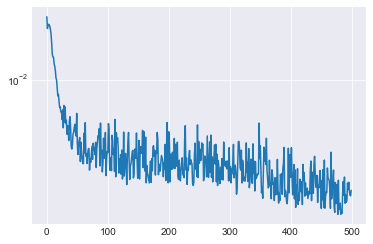

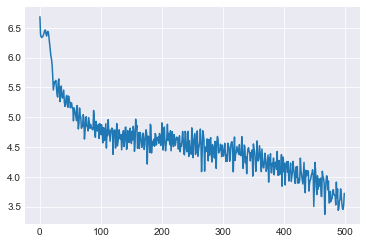

In [49]:
sparse_me_model_4 = maxent_fit(sparse_trajs_4, restraints_4)

Plotting 10 patches in a 3 x 4 grid


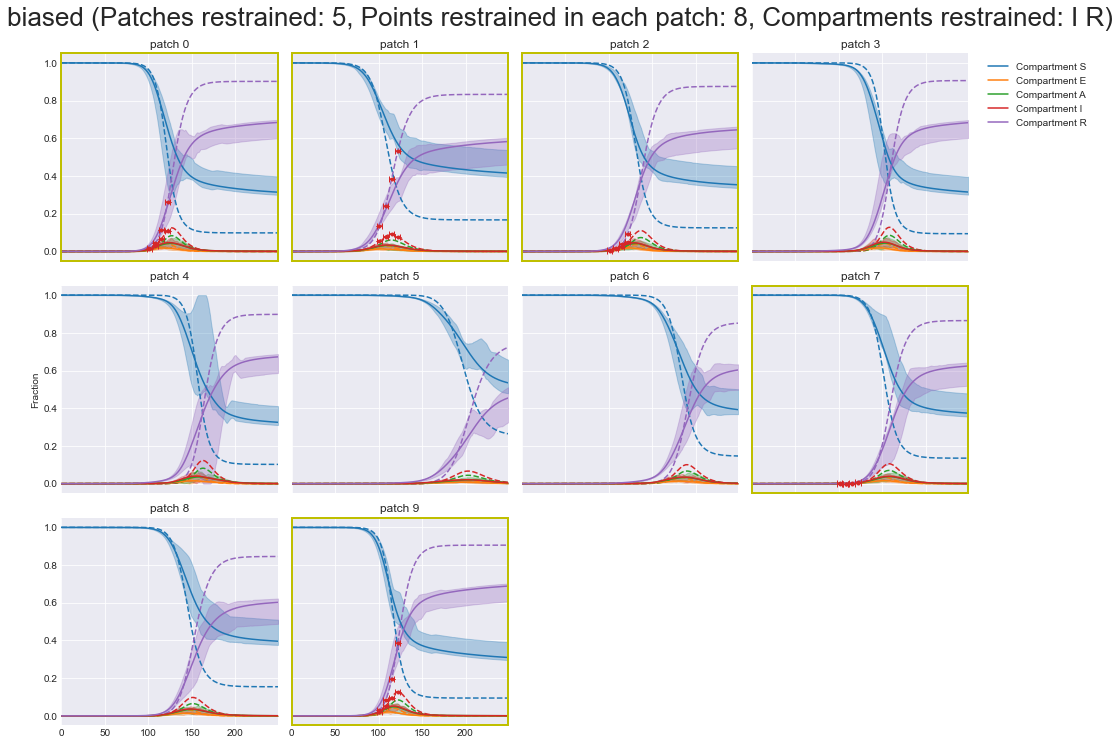

In [50]:
me_w_4 = sparse_me_model_4.traj_weights
weights_dict_4 = {'unbiased':None, 'biased':me_w_4}
compare_patches(sparse_ref_traj_4, sparse_trajs_4, weights_dict_4,'biased', restrained_patches_4, plot_fxns_list_4,
                patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

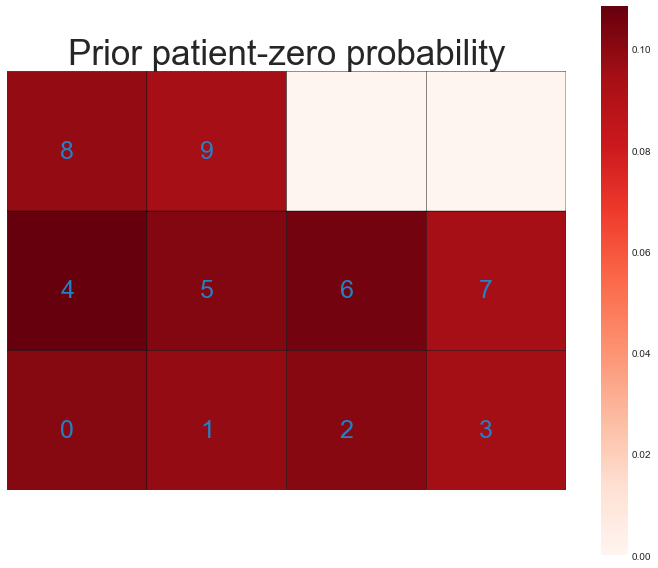

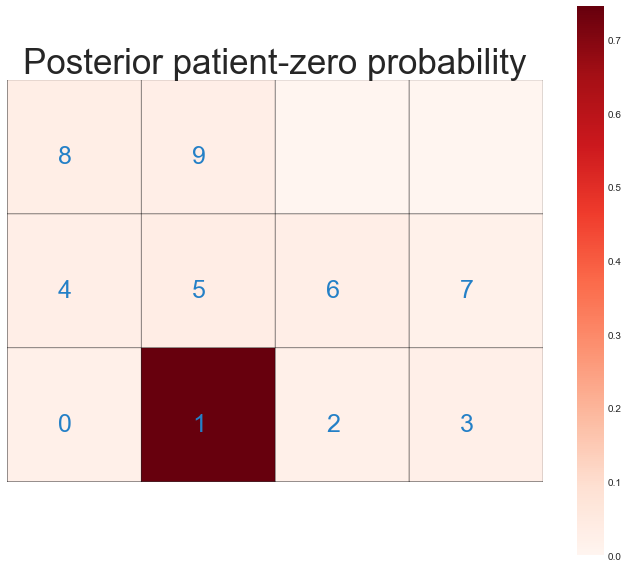

In [51]:
prior_exposed_patch_4 = maxentep.exposed_finder(sparse_trajs_4)
maxentep.p0_map(prior_exposed_patch_4, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch_4, M, weights = me_w_4, 
                title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))


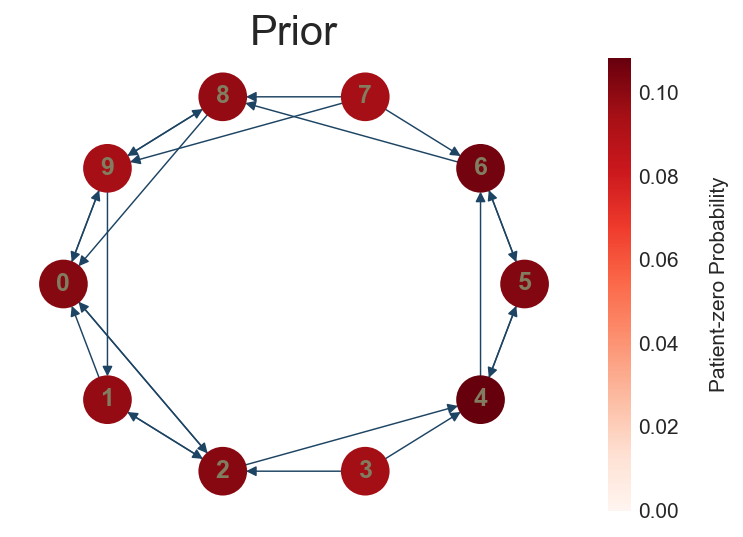

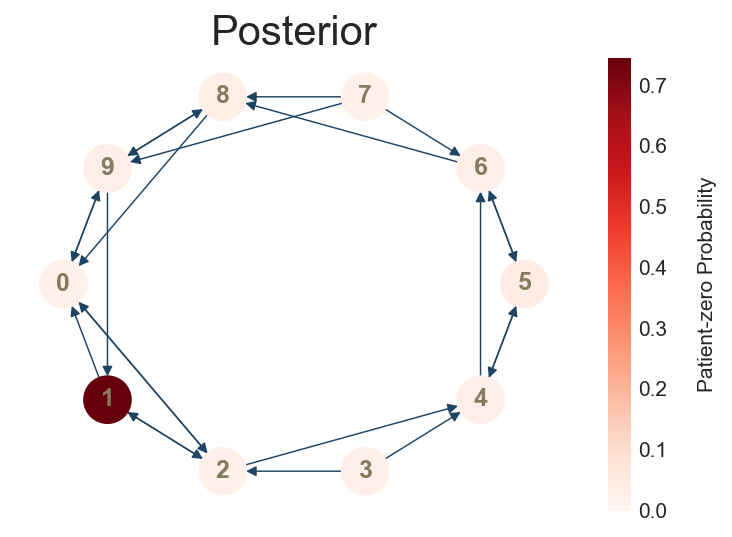

In [52]:
exposed_prob_4 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_4, M)
weighted_exposed_prob_4 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_4, M, weights=me_w_4)
maxentep.draw_graph(graph_4, weights=exposed_prob_4, title='Prior', heatmap=True)
fig, ax = plt.subplots()
maxentep.draw_graph(graph_4, weights=weighted_exposed_prob_4, title='Posterior', heatmap=True)

In [53]:
traj_rmse_4 = traj_loss(sparse_ref_traj_4, sparse_trajs_4, me_w_4)
p0_loss_4 = p0_loss(sparse_trajs_4,me_w_4)
print(f'P0 cross-entropy : {p0_loss_4:.3f}, Traj RMSE : {traj_rmse_4:.3f}')
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob_4, patches), reverse=True)[:5])

P0 cross-entropy : 0.553, Traj RMSE : 0.098
Top 5 posterior probabilities for P0: 
 [(0.745272165042135, 'patch 1'), (0.036910642982432476, 'patch 5'), (0.03322435301588891, 'patch 8'), (0.031235977600881596, 'patch 4'), (0.030085939591095515, 'patch 6')]


Text(0, 0.5, 'Certainty in the Origin of Patinet-zero ')

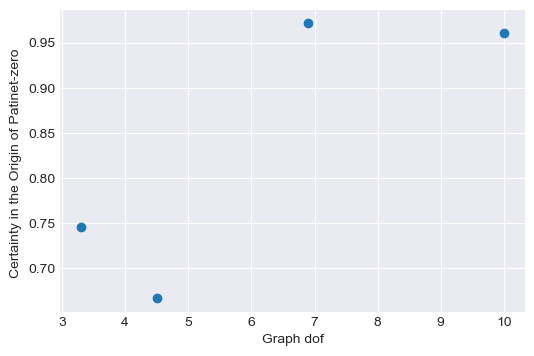

In [65]:
p0_probs = [max(weighted_exposed_prob_1),max(weighted_exposed_prob_2),max(weighted_exposed_prob_3),max(weighted_exposed_prob_4)]
dofs = [dof_1, dof_2, dof_3, dof_4]
fig, ax = plt.subplots(dpi=100)
plt.scatter(dofs,p0_probs)
ax.set_xlabel('Graph dof')
ax.set_ylabel('Certainty in the Origin of Patinet-zero ')